# Experiment on the Chess Transfer Network

This data set comes from the FiveThirtyEight story [American Chess is Great Again](https://fivethirtyeight.com/features/american-chess-is-great-again/). The data were collected [here](https://github.com/fivethirtyeight/data/blob/master/chess-transfers/README.md). 

In [1]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation, prep_data
import pandas as pd
%matplotlib inline

In [49]:
data_dir = 'data/chess_transfers/'
t_start = 6
top_n = 15
n = top_n

T, timesteps, labels = prep_data.prep_chess(data_dir, top_n = top_n)
# labels = list(labels)
# labels = list(np.concatenate((np.array(['NA']), np.array(labels))))
# df.groupby('endorsed').size().nlargest(10)
# T, timesteps,  = prep_data.top_n_filter(df, labels = labels, top_n = top_n)
# T, timesteps, labels = prep_data.prep_chess(data_dir, top_n = top_n)

T, timesteps, A0, n_obs = prep_data.initial_condition(T, timesteps, t_start)

In [57]:
# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

lam_grid = 101
b_grid = 101

sr = estimation.likelihood_surface(T, 
                                  LAMBDA = np.linspace(0, 1, lam_grid), 
                                  BETA   = np.linspace(0, 5, b_grid), 
                                  A0 = A0, 
                                  fun = lambda A: SpringRank.SpringRank(A + .001*np.ones_like(A)), 
                                  alpha = .0001) 

deg = estimation.likelihood_surface(T, 
                                      np.linspace(0, 1, lam_grid), 
                                      np.linspace(0, 5, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: A.sum(axis = 1))

uniform = estimation.likelihood_surface(T, 
                                      np.linspace(0.5, 1, lam_grid), 
                                      np.linspace(0, 5, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: np.ones(A.shape[0]))

pr = estimation.likelihood_surface(T, 
                                      np.linspace(0, 1, lam_grid), 
                                      np.linspace(1, 5, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: estimation.pageRank(A + .01))

In [58]:
for result in [sr, deg, uniform, pr]:
    print(round(result['M'].max()/n_obs.sum(), 2), estimation.get_estimates(result))

-4.27 {'beta': 0.45, 'lambda': 0.04, 's_beta': 0.032943212435689345, 's_lambda': 0.20730639038681906}
-4.25 {'beta': 0.6000000000000001, 'lambda': 0.76, 's_beta': 0.0355851009738403, 's_lambda': 0.41214146465513707}
-4.31 {'beta': 0.0, 'lambda': 0.5, 's_beta': nan, 's_lambda': nan}
-4.27 {'beta': 2.3200000000000003, 'lambda': 0.5700000000000001, 's_beta': 0.21814101917686754, 's_lambda': 0.6135118100185242}


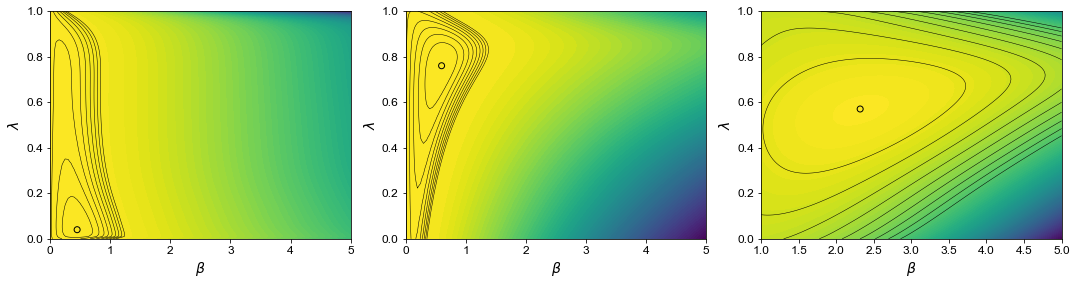

In [59]:
fig, axarr = plt.subplots(1, 3, sharex = False, sharey = False, figsize = (15, 4))

results = [sr, deg,  pr]

for i in range(3):
    
    res = results[i]

    hat = estimation.get_estimates(res)

#     fig = plt.figure(figsize = (5,4))
#     ax = fig.add_subplot(111)

    M_ = res['M']

    xg, yg = np.meshgrid(res['BETA'], res['LAMBDA'])

    im = axarr[i].contourf(xg, yg, M_/n_obs, levels = 100)
    axarr[i].contour(xg, yg, M_/n_obs, 
               levels = np.linspace(M_.max()/n_obs - .1, 
                                    M_.max()/n_obs, 10), 
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

    axarr[i].set(xlabel = r'$\beta$',
           ylabel = r'$\lambda$')

    beta_hat = hat['beta']
    lambda_hat = hat['lambda']

    axarr[i].scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')
    
    plt.tight_layout()

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [60]:
hat = estimation.get_estimates(sr)

BETA = sr['BETA']
LAMBDA = sr['LAMBDA']

M = sr['M']

tau = timesteps

# t = T_.shape[0]
# lam = lambda_hat
n_rounds = T.shape[0]
# beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T, hat['lambda'], A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, top_n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], hat['beta'])
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

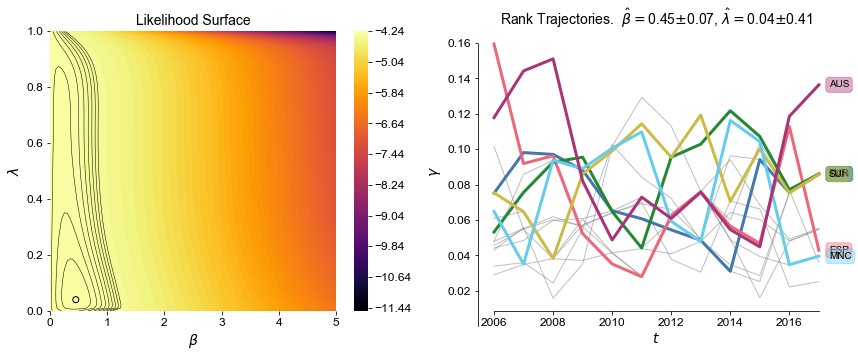

In [61]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

tau = timesteps

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M / n_obs, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M/n_obs, 
           levels = np.linspace(M.max()/n_obs-.1, 
                                M.max()/n_obs, 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')


ax1.scatter(hat['beta'], hat['lambda'], color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

    
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

ax2 = fig.add_subplot(122)

k = 0

for l in range(top_n):
    if l not in top_trajectories:
        ax2.plot(tau, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(top_n):
    if l in top_trajectories: 
        name = labels[l]
        ax2.plot(tau, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 label = name, color = cset[k])
        
        ax2.annotate(labels[l],
                  xy=(tau.max(), GAMMA[-1:,l] ), xycoords='data',
                  xytext=(10, 0), textcoords='offset points',
                  size=10, va="center", color = 'black',
                  bbox=dict(boxstyle="round",  color = cset[k], alpha = .4)
#                   arrowprops=dict(arrowstyle="wedge,tail_width=1.",
#                                   fc=(1.0, 0.7, 0.7), ec="none",
#                                   patchA=None,
#                                   patchB=el,
#                                   relpos=(0.2, 0.5)))
                    )
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())
ax2.spines['bottom'].set_bounds(tau.min(), tau.max())

ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories.  $\hat{\beta} = $' + str(round(hat['beta'], 2)) + r'$\pm$' + str(round(2*hat['s_beta'], 2)) + r', $\hat{\lambda} = $' + str(round(hat['lambda'], 2)) + r'$\pm$' + str(round(2*hat['s_lambda'], 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/chess_exchange.png', dpi = 300, bbox_inches = 'tight')

In [40]:
labels

{0: 'USA',
 1: 'GER',
 2: 'CAN',
 3: 'ESP',
 4: 'RUS',
 5: 'FRA',
 6: 'BIH',
 7: 'CRO',
 8: 'TUR',
 9: 'AUT',
 10: 'CZE',
 11: 'SUI',
 12: 'MNC',
 13: 'AUS',
 14: 'ENG'}